# Get Nike locations

#### Load Python tools and Jupyter config

In [1]:
%load_ext lab_black

In [2]:
import json
import requests
import pandas as pd
import geopandas as gpd
from bs4 import BeautifulSoup
from tqdm.notebook import tqdm, trange

In [3]:
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 1000
pd.options.display.max_colwidth = None

## Read data

#### All the locations

In [4]:
headers = {
    "authority": "api.nike.com",
    "content-type": "application/json; charset=UTF-8",
    "user-agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36",
}

response = requests.get(
    "https://api.nike.com/store/store_locations/v1?fields=storeNumber,storeServices,id,name,address,businessConcept,company,coordinates,distance,facilityType,imageUrl,localizations,storeConcept,offerings,operationalDetails,phone,region,slug,timezone,defaultLanguage&search=(facilityType%20=in=%20(%20%27NIKE_OWNED_STORE%27))%20and%20(businessConcept%20=out=%20(%27EMPLOYEE_STORE%27,%20%27BRAND_POPUP%27))%20and%20(brand%20!=%20%27CONVERSE%27)%20and%20(coordinates=geoProximity=%7B%22latitude%22%3A34%2C%22longitude%22%3A-118.43%2C%22maxDistance%22%3A50000%2C%22measurementUnits%22%3A%22mi%22%7D)&count=2000",
    headers=headers,
)

In [5]:
len(response.json()["objects"])

930

In [6]:
data = response.json()["objects"]

In [7]:
src = pd.DataFrame(data).drop(
    ["storeServices", "offerings", "imageUrl", "id", "businessConcept", "distance"],
    axis=1,
)

In [8]:
src[
    [
        "address1",
        "address2",
        "area",
        "city",
        "state",
        "postalCode",
        "country",
        "iso2Country",
        "address3",
        "county",
    ]
] = pd.json_normalize(src["address"])

In [9]:
src["open_date"] = pd.json_normalize(src["operationalDetails"])["openingDate"]

In [10]:
src[["latitude", "longitude"]] = pd.json_normalize(src["coordinates"])

In [11]:
df = src[
    [
        "storeNumber",
        "facilityType",
        "phone",
        "name",
        "region",
        "company",
        "address1",
        "city",
        "state",
        "postalCode",
        "country",
        "open_date",
        "latitude",
        "longitude",
    ]
].copy()

---

## Geography

#### Make a geodataframe from lon/lat

In [12]:
df_geo = df.copy()

In [13]:
gdf = gpd.GeoDataFrame(
    df_geo, geometry=gpd.points_from_xy(df_geo.longitude, df_geo.latitude)
).set_crs("epsg:4326")

<AxesSubplot: >

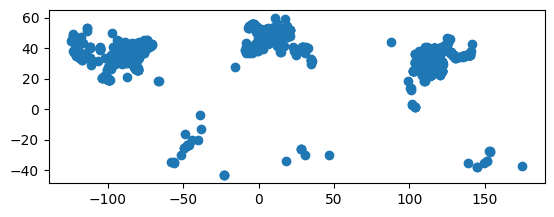

In [14]:
gdf.plot()

---

## Exports

#### CSV

In [15]:
df.to_csv("data/processed/nike_locations.csv", index=False)

#### JSON

In [16]:
df.to_json("data/processed/nike_locations.json", indent=4, orient="records")

#### GeoJSON

In [17]:
gdf.to_file("data/processed/nike_locations.geojson", driver="GeoJSON")